# Annealing test

In [1]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# !nvidia-smi
# numpyro.set_platform("gpu")

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import random, jit, vmap, grad

import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed, condition, trace

%matplotlib inline
%load_ext autoreload 
%autoreload 2

feynmangpu04.cluster.local
gpu [cuda(id=0)]


## Toy model

Define a simple model with normal prior and gaussian mixture likelihood.
Gaussian noising can then be computed analytically.

In [3]:
mean_prior = 0
var_prior = 9
var_mixt = 1

def mixture_model(dim=2, 
                  radius=3,
                  sigma=0,
                  noise_prior=True):
    mean_mixt = radius * jnp.ones(dim) / dim**0.5 # same euclidiean distance between modes for any dim
    if noise_prior:
        var_post = 1 / (1/var_prior + 1/var_mixt)
        mean_post = (mean_prior/var_prior + mean_mixt/var_mixt) * var_post
        var_post = var_post + sigma**2 # noise prior (and likelihood)
    else:
        var_mixtnoise = var_mixt + sigma**2 # noise likelihood only
        var_post = 1 / (1/var_prior + 1/var_mixtnoise)
        mean_post = (mean_prior/var_prior + mean_mixt/var_mixtnoise) * var_post
    # loc = jnp.zeros(dim)
    # loc = loc.at[0].set(radius)
    mode1 = dist.MultivariateNormal(loc= mean_post, covariance_matrix=jnp.eye(dim)*var_post)
    mode2 = dist.MultivariateNormal(loc=-mean_post, covariance_matrix=jnp.eye(dim)*var_post)
    cat = dist.Categorical(jnp.array([.75, .25]))
    mixture = dist.MixtureGeneral(cat, [mode1, mode2])
    mixt =  numpyro.sample('mixt', mixture)
    return mixt


sample_fn = vmap(lambda rng_key, model_kwargs: seed(mixture_model, rng_key)(**model_kwargs), in_axes=(0, None))
from numpyro.infer.util import log_density
def logp_fn(mixt_val, sigma, model_kwargs, temper_prior=True):
    logp = log_density(model=mixture_model, 
                    model_args=(), 
                    model_kwargs=model_kwargs, 
                    params={'mixt':mixt_val})[0]
    if temper_prior:
        var_post = 1 / (1/var_prior + 1/var_mixt)
        return logp * var_post / (var_post + sigma**2)
    else: 
        logprior = dist.MultivariateNormal(loc=mean_prior, covariance_matrix=jnp.eye(model_kwargs['dim'])*var_prior).log_prob(mixt_val)
        return (logp * var_mixt + logprior * sigma**2) / (var_mixt + sigma**2)

score_fn = grad(logp_fn, argnums=0)
logp_vfn = vmap(logp_fn, in_axes=(0, None, None, None))
score_vfn = vmap(score_fn, in_axes=(0, None, None, None))

def p_vfn(x, sigma, model_kwargs, temper_prior=True):
    return jnp.exp(logp_vfn(x, sigma, model_kwargs, temper_prior))
# logp_fn(jnp.array([[1],[2]]),sigma=0,model_kwargs={}),\
# logp_fn(jnp.array([[1,1],[2,2]]),sigma=0,model_kwargs={}),\
# logp_fn(jnp.array([1]),sigma=0,model_kwargs={}) + logp_fn(jnp.array([2]),sigma=0,model_kwargs={})

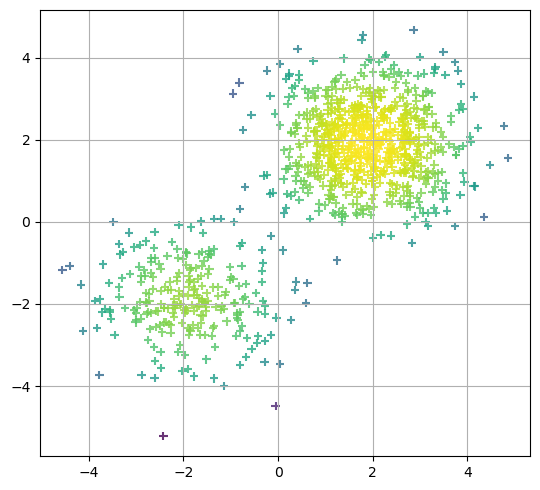

In [4]:
init_key = random.PRNGKey(0)
model_kwargs = {'dim':2, 'radius':3}
n_samples = 1000
samples = sample_fn(random.split(init_key, n_samples), model_kwargs)
sigma = 0
logps = logp_vfn(samples, sigma, model_kwargs, True)
scores = score_vfn(samples, sigma, model_kwargs, True)

plt.figure(figsize=(5.5,5))
plt.scatter(*samples[:, :2].T, c=logps, marker='+', alpha=.8)
plt.grid()
plt.tight_layout()
plt.show();

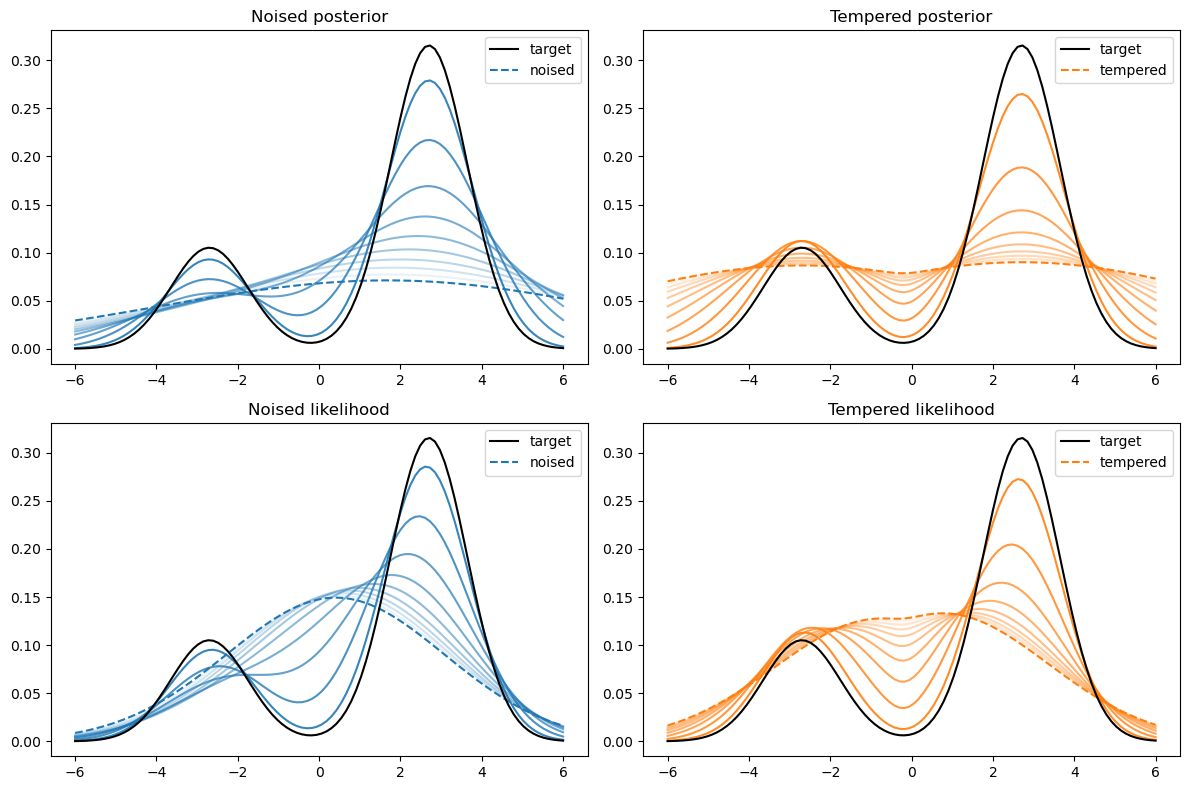

In [11]:
def plot_tempnoise(xs, border, model_kwargs, sigmas, noise, noise_prior):
    model_kwargs['noise_prior'] = noise_prior
    model_kwargs['sigma'] = 0
    plt.plot(xs, p_vfn(xs, 0, model_kwargs), 'k', label='target', zorder=np.inf)
    for i_sigma, sigma in enumerate(sigmas):
        if noise:
            color='C0'
            model_kwargs['sigma'] = sigma
            temper = 0
            label = "noised"
        else:
            color='C1'
            model_kwargs['sigma'] = 0
            temper = sigma
            label = "tempered"
        # tempered
        pdf_temp = p_vfn(xs, temper, model_kwargs, temper_prior=noise_prior)
        if not noise:
            pdf_temp = pdf_temp / (2* border * pdf_temp.mean())
        if i_sigma != len(sigmas)-1:
            alpha = float(1-sigma/max(sigmas))
            label=None
        else:
            alpha = 1
            color += '--'
        plt.plot(xs, pdf_temp, color, alpha=alpha, label=label)
        plt.legend()

# from scipy.integrate import simps # XXX
model_kwargs = {'dim':1, 'radius':3, 'sigma':0}
border = 2*model_kwargs['radius']
xs = jnp.linspace(-border,border,100)
sigmas = jnp.linspace(0.5,5,10)

plt.figure(figsize=(12,8))
plt.subplot(221)
plot_tempnoise(xs, border, model_kwargs, sigmas, noise=True, noise_prior=True)
plt.title("Noised posterior")
plt.subplot(222)
plot_tempnoise(xs, border, model_kwargs, sigmas, noise=False, noise_prior=True)
plt.title("Tempered posterior")
plt.subplot(223)
plot_tempnoise(xs, border, model_kwargs, sigmas, noise=True, noise_prior=False)
plt.title("Noised likelihood")
plt.subplot(224)
plot_tempnoise(xs, border, model_kwargs, sigmas, noise=False, noise_prior=False)
plt.title("Tempered likelihood")
plt.tight_layout()
plt.show();

## Sampling from SDE

In [28]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, ReversibleHeun
t0, t1 = 5., 0.
model_kwargs = {'dim':1, 'radius':2, 'sigma':0}
drift = lambda t, y, args: - 0.5 * score_fn(y, t/t0, model_kwargs) # Now sigma is a function of time
diffusion = lambda t, y, args: jnp.ones_like(y)
solver = Euler()
saveat = SaveAt(ts=jnp.linspace(t0,t1))

@jax.jit
@jax.vmap
def get_samples(y, seed):
  brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-4, shape=(), key=seed)
  terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
  return diffeqsolve(terms, solver, t0, t1, dt0=-0.001, y0=y, max_steps=10_000, saveat=saveat).ys

In [29]:
model_kwargs = {'dim':1, 'radius':3, 'sigma':0}
n_samples = 100_000
init_samples = sample_fn(random.split(init_key, n_samples), model_kwargs)

res = get_samples(init_samples, random.split(random.PRNGKey(8), n_samples))

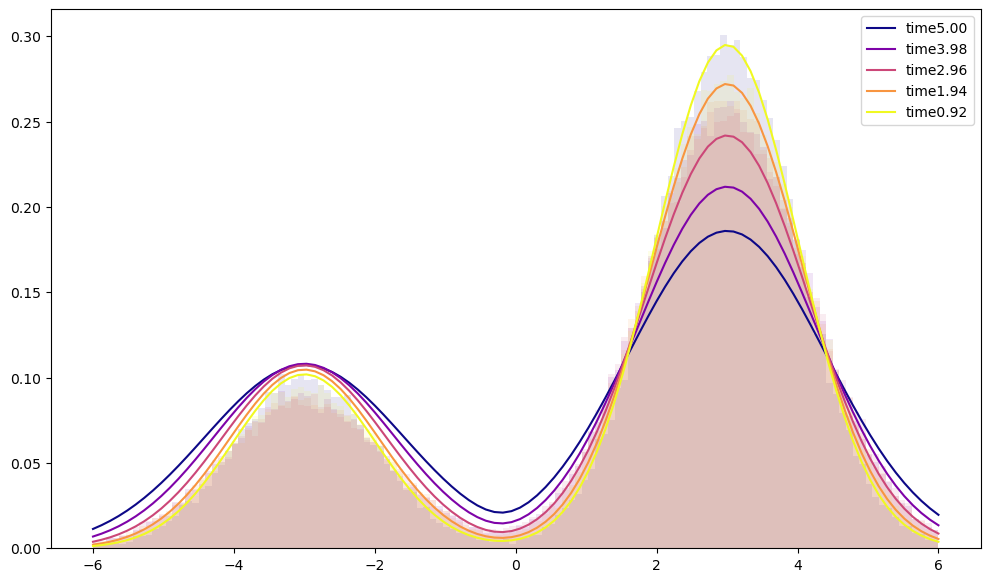

In [31]:
# T=5
colors = plt.cm.plasma(np.linspace(0,1,5))
border = 2*model_kwargs['radius']
xs = jnp.linspace(-border,border,100)

plt.figure(figsize=[12,7])
for i,t in enumerate(saveat.subs.ts[::10]):
  # posterior = make_likelihood(t/t0).prob(x**2)*make_prior(t/t0).prob(x)
  model_kwargs['sigma'] = 0
  pdf_temp = p_vfn(xs, t/t0, model_kwargs)
  pdf_temp = pdf_temp / (2* border * pdf_temp.mean())
  plt.plot(xs, pdf_temp, color=colors[i], label=f"{t=:.2f}")
  plt.hist(res[:,i*10,0],128,range=[-border,border], density=True,alpha=0.1,color=colors[i]);
plt.legend();